# NOTES



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os, os.path

## Load data

In [2]:
# point to the stats.npz you want to load. You can generate the stats.npz with prepare_analysis.py
data = np.load('../checkpoints_passnet/stats.npz')

print(data['token_counts'].shape, data['class_counts'].shape, data['instance_class'].shape)
token_counts = data['token_counts']
class_counts = data['class_counts']
instance_class = data['instance_class']
data.close()

(197, 8192) (1020, 8192) (2720886, 2)


In [3]:
#helper function
idx2class = lambda x: f"{instance_class[x,0]}_{instance_class[x,1]}"

## Basic inspections of counts for prototypes and tokens

In [4]:
# class counts for this prototype - it seems classes that score high on same prototype are conceptually similar 
f = 3008
for t in np.argsort(class_counts[:,f], axis=None)[-25:]:
    print(t, idx2class(t), class_counts[t,f])

325 0_0 0
326 0_0 0
327 0_0 0
328 0_0 0
329 0_0 0
330 0_0 0
331 0_0 0
332 0_0 0
349 0_0 0
333 0_0 0
335 0_0 0
336 0_0 0
337 0_0 0
338 0_0 0
339 0_0 0
340 0_0 0
341 0_0 0
342 0_0 0
343 0_0 0
344 0_0 0
345 0_0 0
346 0_0 0
347 0_0 0
334 0_0 0
1019 0_0 0


In [5]:
# what are the most frequent prototypes for token f, token 0 is cls token
f = 0 
for t in np.argsort(token_counts[f], axis=None)[-15:]:
    print(t, token_counts[f,t])

1098 14434
1528 15192
1901 15510
3054 15627
3481 16057
7596 16689
1717 16910
1234 21402
5465 23228
3934 23417
966 23524
2920 26780
6460 32556
6471 386567
582 781578


In [6]:
sumt = token_counts.sum(axis=0)
sumt[sumt == 0] = 1
norm_tokens = token_counts / sumt # normalise token counts

In [7]:
 # what are the most frequent prototypes for this token in the normalised setting
f = 20
for t in np.argsort(norm_tokens[f], axis=None)[-25:]:
    print(t, norm_tokens[f,t], token_counts[f,t])

7727 0.00816326530612245 2
3459 0.00817497310864109 114
6972 0.008394543546694649 16
5263 0.00847001882226405 252
7222 0.00847457627118644 1
8119 0.008487654320987654 88
2525 0.00851063829787234 88
4713 0.008608858390517778 69
279 0.008620689655172414 5
7669 0.008768679757935037 71
2799 0.009362922208123056 4833
334 0.009423294383716547 100
6501 0.00967186153966638 247
6912 0.010073544694084963 5283
7188 0.010169858271124094 94
2452 0.010345797019960641 184
4623 0.011157540407997447 1538
324 0.011772578048219476 563
5918 0.01243419229703519 359
6636 0.012567049808429119 82
7186 0.012984718664428938 147
18 0.014404678076110584 941
7461 0.01822821728034998 150
7787 0.021610944472894873 1477
5487 0.022127752343579683 203


In [8]:
class_vari = np.sum(class_counts > 0,0) # find prototypes that occur for many classes
for p in np.argsort(class_vari)[::-1][:15]:
    print(p, class_vari[p])

6471 1020
582 1020
1971 878
7787 867
3419 858
2920 831
6912 816
4394 812
6611 781
5918 767
1717 746
1771 729
6501 726
324 719
6737 719


## Find difference across the spatial layout of tokens

In [9]:
# find prototypes which differ most between A and B (should be Top and Bottom)
a_tokens = token_counts[1:99].copy()
b_tokens = token_counts[99:].copy()
print(a_tokens.shape, b_tokens.shape)

a_sum = a_tokens.sum(0).astype(int)
b_sum = b_tokens.sum(0).astype(int)
diff = np.abs(a_sum - b_sum)
for x in np.argsort(diff)[-5:]:
    print(x, diff[x], a_sum[x], b_sum[x])

(98, 8192) (98, 8192)
6611 380581 154617 535198
2799 424191 470185 45994
6912 436934 480631 43697
582 5063796 227107058 222043262
6471 5131813 34619457 39751270


In [10]:
# normalise for token frequency
ndiff = diff / sumt
for x in np.argsort(ndiff)[-15:]:
    print(x, ndiff[x], a_sum[x], b_sum[x])

5540 0.928935488568516 4148 112591
7548 0.941921858500528 935 31263
2291 0.9424686192468619 165 5571
3011 0.968503937007874 125 2
6007 0.971662406119335 1427 99493
4647 0.9756637168141593 88 7144
5487 0.9801613254850665 9083 91
3316 0.9956197985107315 25 11390
6846 1.0 0 23
5350 1.0 6 0
502 1.0 1 0
894 1.0 0 45
1309 1.0 3 0
6215 1.0 2 0
5535 1.0 1 0


In [11]:
# try 3-way split
x_tokens = token_counts[1:66].copy()
y_tokens = token_counts[66:132].copy()
z_tokens = token_counts[132:].copy()
print(x_tokens.shape, y_tokens.shape, z_tokens.shape)

x_sum = x_tokens.sum(0).astype(int)
y_sum = y_tokens.sum(0).astype(int)
z_sum = z_tokens.sum(0).astype(int)

#tdiff = np.abs(x_sum - y_sum) + np.abs(x_sum - z_sum) + np.abs(y_sum - z_sum)
tdiff = np.abs(x_sum - z_sum)
for x in np.argsort(tdiff)[-15:]:
    print(x, tdiff[x], x_sum[x], y_sum[x], z_sum[x])

(65, 8192) (66, 8192) (65, 8192)
7787 53986 54939 12453 953
2307 77849 5459 81418 83308
6896 77930 30049 55285 107979
558 78956 118458 50622 197414
5540 79109 741 36148 79850
4623 82526 84104 52162 1578
5309 85271 77684 111568 162955
3090 91424 96553 109054 5129
6007 91808 732 7648 92540
6611 272430 31272 354841 303702
1398 277887 10534 94092 288421
6912 358304 369758 143116 11454
2799 374714 398107 94679 23393
6471 4828457 21628964 26284342 26457421
582 4886738 152571284 148894490 147684546


In [12]:
# normalise
ntdiff = tdiff / sumt
for x in np.argsort(ntdiff)[-35:]:
    print(x, ntdiff[x], x_sum[x], y_sum[x], z_sum[x])

4623 0.5986912741940165 84104 52162 1578
324 0.6000250925286996 32309 11899 3614
7222 0.6101694915254238 77 36 5
7188 0.6102996862490533 5799 3286 158
7367 0.6153846153846154 1 3 9
7855 0.6167539928034846 1302 27751 50152
5918 0.618973399833749 18671 9401 800
2452 0.6294630306438009 11571 5838 376
334 0.6307010931021485 6864 3577 171
4509 0.6417658292933744 242 9270 17716
5013 0.6435276263279186 370 5602 11819
3313 0.6448712352684417 408 7320 15182
5469 0.6543795329560851 412 7849 16833
6567 0.6730988438365088 247 3521 8514
5540 0.6776569955199205 741 36148 79850
6912 0.6832086613797878 369758 143116 11454
7186 0.7004681565232753 8058 3135 128
1398 0.7070034524957448 10534 94092 288421
653 0.71875 23 9 0
7548 0.7226225231380831 149 8633 23416
18 0.7249334108930594 47713 17257 356
2799 0.7259296570028188 398107 94679 23393
5580 0.7643402787284724 637 7333 28553
8122 0.7742899850523169 21 411 1575
8026 0.7824224772999828 12 1246 4579
7787 0.7899041627039286 54939 12453 953
7461 0.7970591

### Investigate spatial distribution of prototypes

0 0
0 0


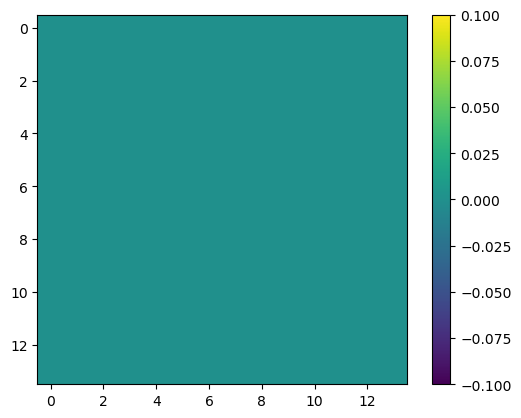

In [13]:
f = 3980 # the prototype to focus on - to see how it is spatially distributed
plt.imshow(norm_tokens[1:, f].reshape(14,14))
plt.colorbar()
print(token_counts[1:,f].min(), token_counts[1:,f].max()) # if these are 0 (or very close to)
print(token_counts[0,f].min(), token_counts[0,f].max()) # and these are nonzero - its a 'class prototype'

## Investigate correlations

### between prototypes

In [14]:
pt_cor = np.corrcoef(norm_tokens+0.0001, rowvar=False)
pt_cor.shape, pt_cor.min(), pt_cor.max()

((8192, 8192), -0.8817668671928927, 1.0)

In [15]:
# What are the prototypes most strongly correlated with prototype f?
f = 0
for x in np.argsort(pt_cor[f, :])[-15:][::-1]:
    print(x, pt_cor[f, x])

8191 0.9999999999999999
2893 0.9999999999999999
2862 0.9999999999999999
2863 0.9999999999999999
2864 0.9999999999999999
2865 0.9999999999999999
2866 0.9999999999999999
2867 0.9999999999999999
2868 0.9999999999999999
2869 0.9999999999999999
2870 0.9999999999999999
2871 0.9999999999999999
2872 0.9999999999999999
2873 0.9999999999999999
2875 0.9999999999999999


### between tokens

In [16]:
tk_cor = np.corrcoef(norm_tokens, rowvar=True) # this is correlation between tokens
tk_cor.min(), tk_cor.shape, tk_cor[1:,1:].min()

(-0.03398720303402837, (197, 197), 0.0031490115475466705)

In [17]:
# What are the tokens most strongly correlated with token f?
f = 0
for x in np.argsort(tk_cor[f, :])[-15:][::-1]:
    print(x, tk_cor[f, x])

0 0.9999999999999999
14 0.025605584552795473
13 0.022847334427601514
1 0.01895327646824686
12 0.016768465188286088
2 0.0163795417129212
3 0.011906886906460697
4 0.01099593671476262
11 0.01012929606951131
5 0.009275380825716852
196 0.006544223767552434
194 0.003387501003165227
183 0.0032634854791633084
6 0.00319771183342828
15 0.002403864113528254


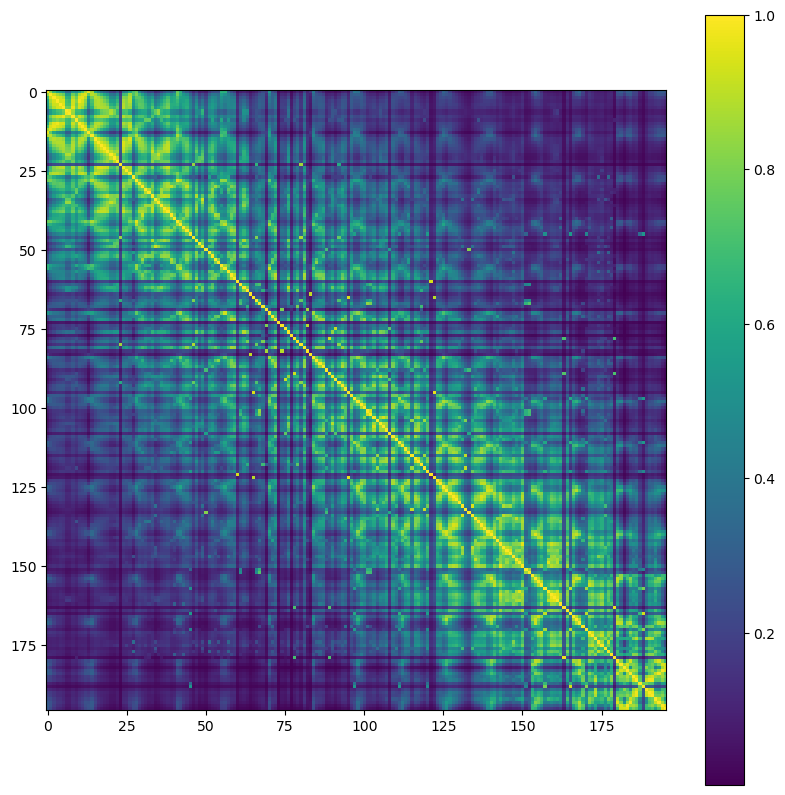

In [18]:
# visualise the correlations between tokens
plt.figure(figsize=(10,10))
plt.imshow(tk_cor[1:,1:])
plt.colorbar()

## Look at correlations between tokens based on mask

As in Figure 1 in the supplementary

In [19]:
mask_folder = "samples" # output dir

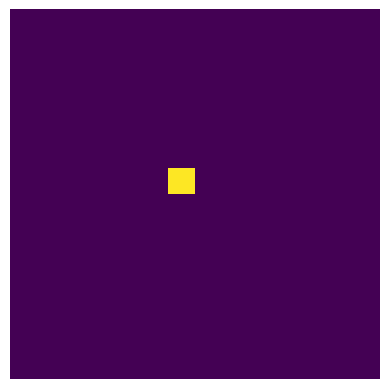

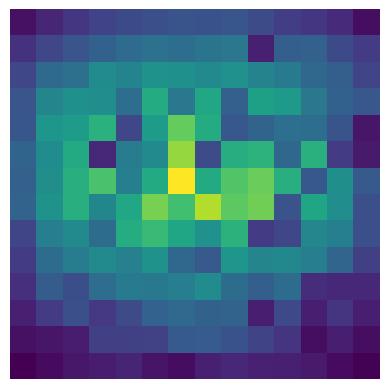

In [20]:
mask = np.zeros((14,14), bool)
mask[6,6] = 1

pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_6_6_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_6_6.jpg"), bbox_inches='tight')
plt.show()

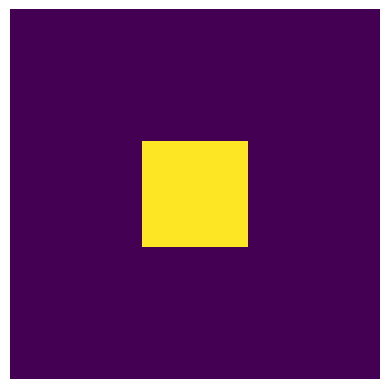

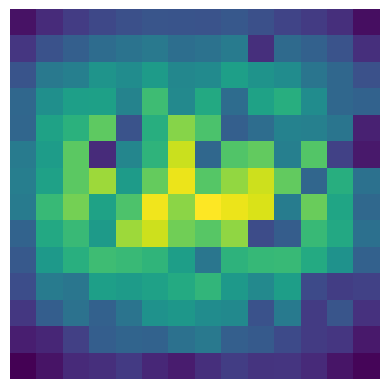

In [21]:
mask = np.zeros((14,14), bool)
mask[5:9,5:9] = 1

pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_59_59_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_59_59.jpg"), bbox_inches='tight')
plt.show()

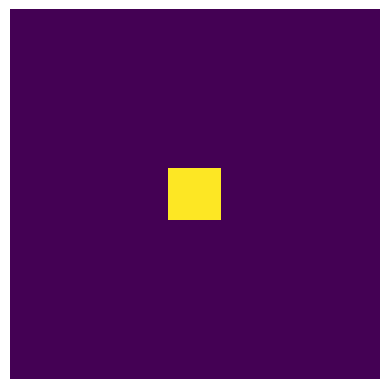

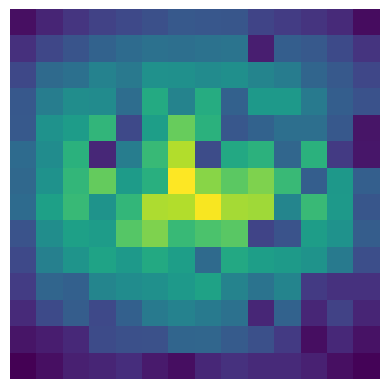

In [22]:
mask = np.zeros((14,14), bool)
mask[6:8,6:8] = 1
pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_68_68_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_68_68.jpg"), bbox_inches='tight')
plt.show()

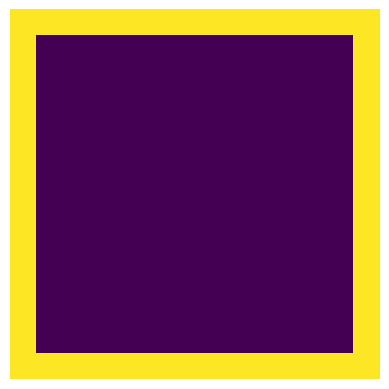

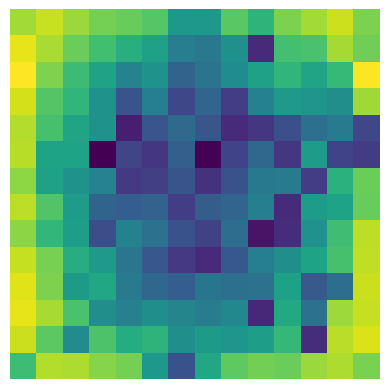

In [23]:
mask = np.zeros((14,14), bool)
mask[0:,0:1] = 1
mask[0:,-1:] = 1
mask[0:1:,0:] = 1
mask[-1:,0:] = 1
pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_edge_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_edge.jpg"), bbox_inches='tight')
plt.show()

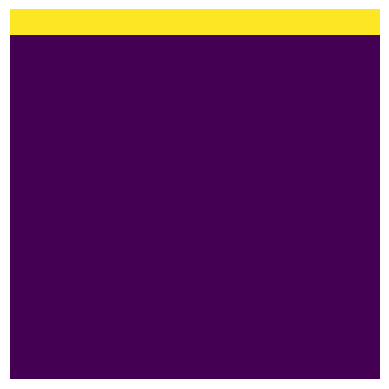

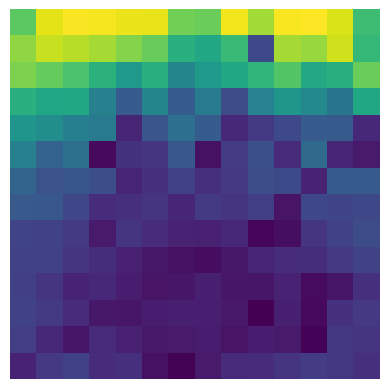

In [24]:
mask = np.zeros((14,14), bool)
mask[0:1:,0:] = 1
pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_top_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_top.jpg"), bbox_inches='tight')
plt.show()

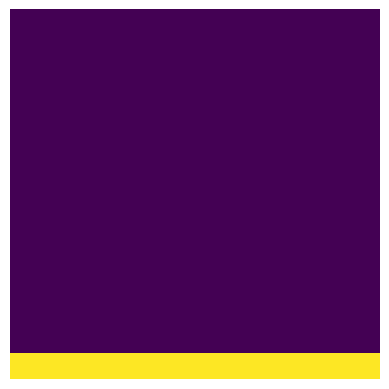

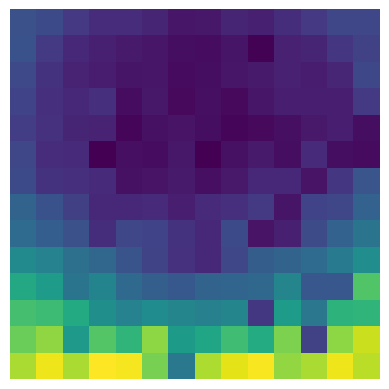

In [25]:
mask = np.zeros((14,14), bool)
mask[-1:,0:] = 1
pscor = tk_cor[1:,1:][mask.flatten(), :].mean(0)

plt.imshow(mask)
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_bottom_mask.jpg"), bbox_inches='tight')
plt.show()
plt.imshow(pscor.reshape(14,14))
plt.axis('off')
plt.savefig(os.path.join(mask_folder, "mask_bottom.jpg"), bbox_inches='tight')
plt.show()